# 音频信号数据增强

In [1]:
import librosa
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示符号
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] # 用来显示负号和中文的方法
fs = 22050

signal_data, sr = librosa.load('UrbanSound8K/audio/fold1/101415-3-0-2.wav', sr=fs, mono=True)

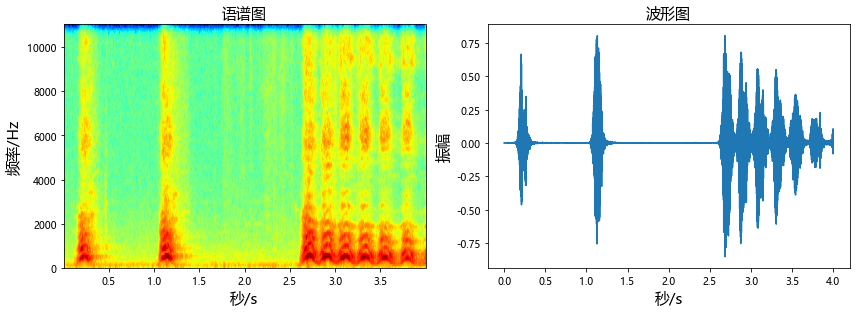

In [2]:
def plot_wave_spec(wave_data):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title("语谱图", fontsize=15)
    plt.specgram(wave_data, Fs=fs, scale_by_freq=True, sides='default', cmap="jet")
    plt.xlabel('秒/s', fontsize=15)
    plt.ylabel('频率/Hz', fontsize=15)

    plt.subplot(2, 2, 2)
    plt.title("波形图", fontsize=15)
    time = np.arange(0, len(wave_data)) * (1.0 / fs)
    plt.plot(time, wave_data)
    plt.xlabel('秒/s', fontsize=15)
    plt.ylabel('振幅', fontsize=15)

    plt.tight_layout()
    plt.show()

plot_wave_spec(signal_data)

spectrogram shape:  (1025, 173)


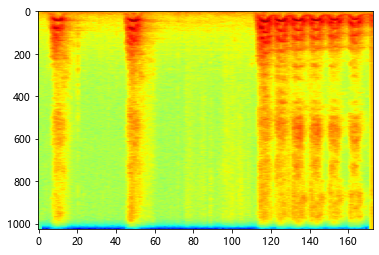

In [3]:
# 获取频谱数据
def get_spectrogram(x):
    D = librosa.stft(x, n_fft=2048)
    spect, phase = librosa.magphase(D)
    log_spect = np.log(spect)
    return spect, log_spect

def plot_spect(spectrogeam):
    plt.imshow(spectrogeam, aspect='auto', cmap='jet')
    plt.show()
spect, log_spect = get_spectrogram(signal_data)
print('spectrogram shape: ', spect.shape)
plot_spect(log_spect)

## 1. 添加噪声
在音频中添加高斯噪声、白噪声或其他类型的噪声

#### 1.1. 通过自定义噪声增益系数来添加

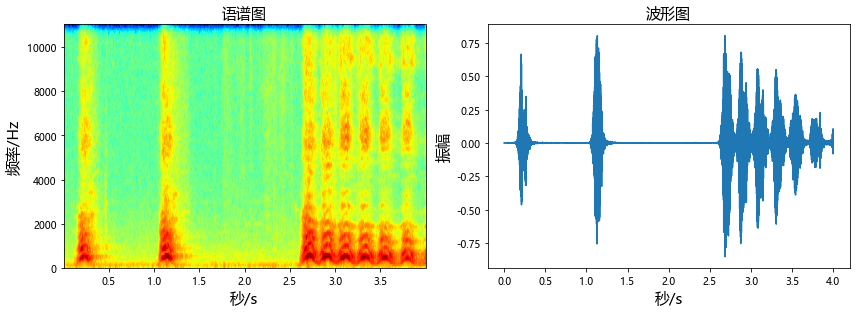

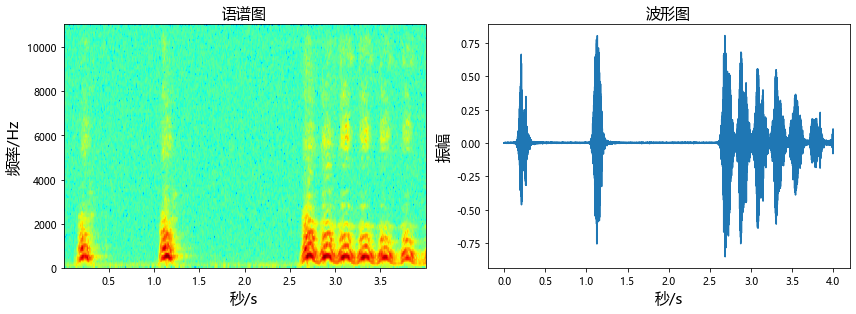

In [4]:
def add_gaussian_noise(audio, noise_level=0.001):
    noise = np.random.normal(loc=0, scale=1, size=len(audio))
    noisy_audio = audio + noise * noise_level
    return noisy_audio

augmented_audio = add_gaussian_noise(signal_data, noise_level=0.001)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

#### 1.2. 通过信噪比的公式推导出噪声的增益系数
$$SNR=10*log_{10}(\frac{S^2}{k^2 \cdot N^2})$$

$$k=\sqrt{\frac{S^2}{N^2 \cdot 10^{\frac{SNR}{10}}}}$$

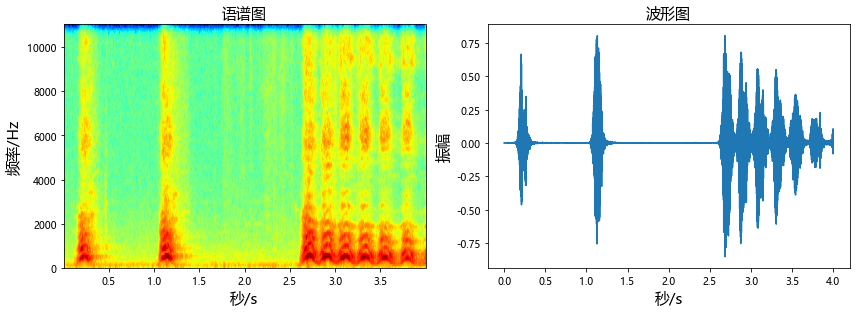

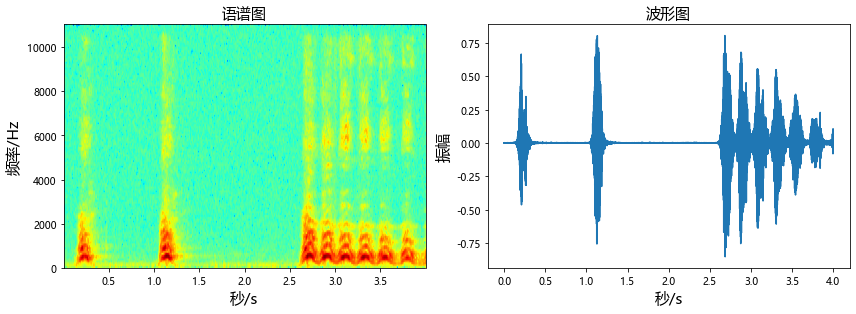

In [5]:
def add_gaussian_noise_snr(audio, snr):
    noise = np.random.normal(loc=0, scale=1,size=len(audio))
    P_signal = np.mean(audio ** 2)
    P_noise = np.mean(noise ** 2)

    k = np.sqrt(P_signal / (P_noise * (10 ** (snr / 10.0))))
    noisy_audio = audio + k * noise
    return noisy_audio

augmented_audio = add_gaussian_noise_snr(signal_data, snr=50)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 2. 音量增强
要增强音频的音量，你可以通过调整每个样本的振幅来实现。语音音量的单位为dB，音量增益可以基于平均音量或者最大瞬时音量，下面公式是基于平均音量推得dB增益
$$dB = 10 \cdot log_{10}(kS)^2$$
$$k = \sqrt{\frac {10 ^ \frac {dB} {10}} {S^2}}$$

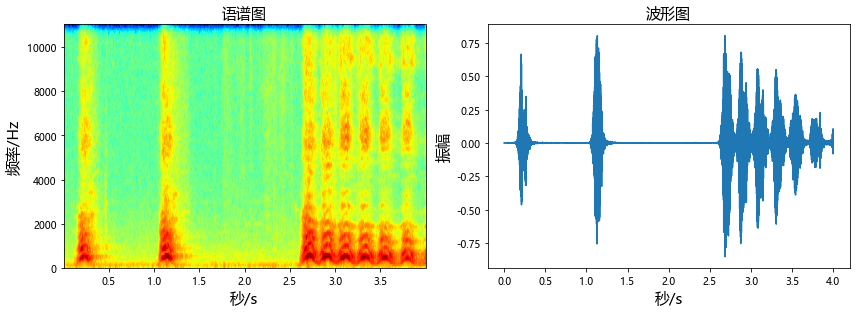

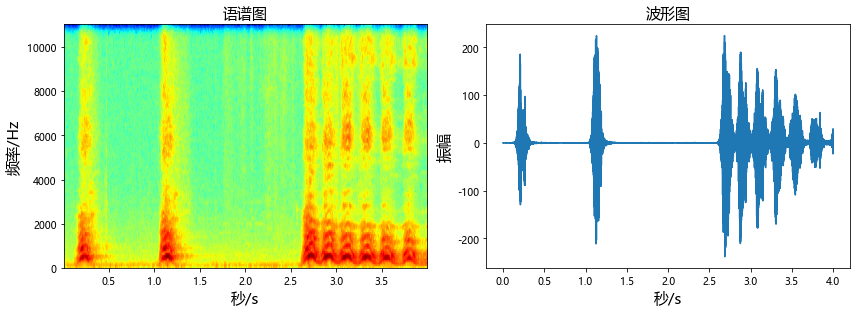

In [6]:
def add_volume(audio, dB):
    P_signal = np.mean(audio ** 2)
    k = np.sqrt(10 ** (dB / 10) / P_signal)
    output = audio * k
    return output

augmented_audio = add_volume(signal_data, dB=30)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 3. 波形位移
在信号处理中，波形位移指的是对信号的时间轴进行平移或移动。这意味着将信号的每个时间点向前或向后移动一定的时间量。波形位移可以用来调整信号在时间上的位置，而不会影响信号的频率或振幅。

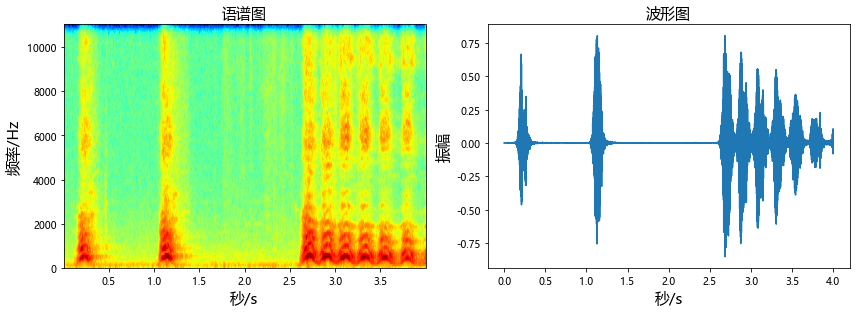

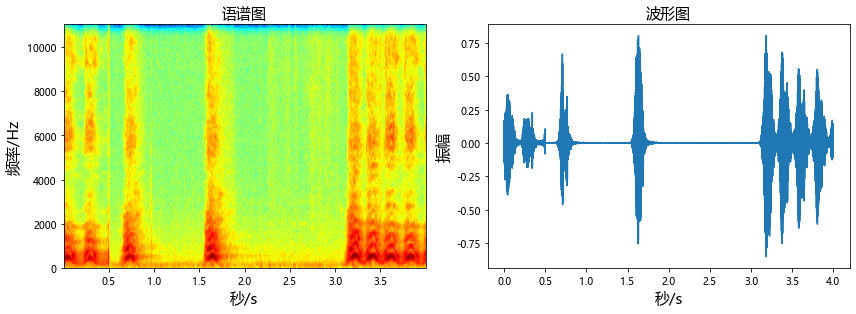

In [7]:
def time_shift(audio, shift):
    return np.roll(audio, int(shift))

augmented_audio = time_shift(signal_data, shift=fs // 2)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 4. 谐波失真
谐波失真是一种非线性失真效果，它通过增加音频信号的谐波分量来改变声音的音色
假设原始音频信号为 $x(t)$，谐波失真的程度由一个参数$ k$ 控制。谐波分量可以表示为 $sin(2πf_h t)$，其中 $f_h$ 是谐波的频率。谐波分量的频率通常是原始音频频率的整数倍

$$y(t) = x(t) + k \cdot \sum_{n=1}^N {sin(2 \pi n \cdot f_n t)}$$

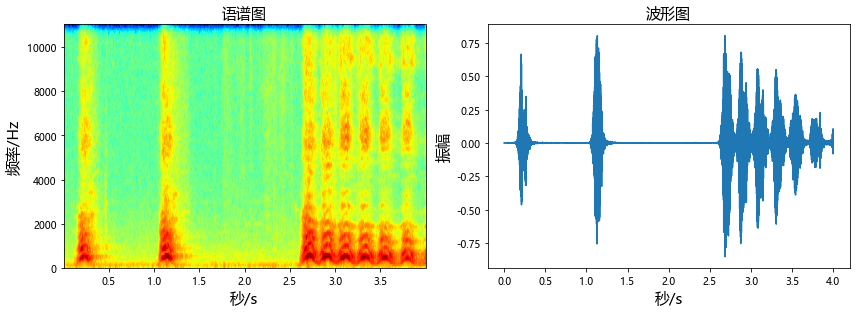

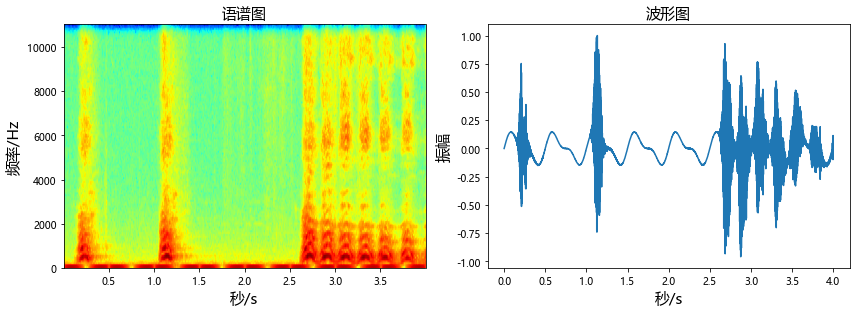

In [8]:
def apply_harmonic_distortion(audio, distortion_factor):
    # 计算谐波分量
    harmonic1 = audio + distortion_factor * np.sin(2 * np.pi * 2 * np.arange(len(audio)) / sr)
    harmonic2 = audio + (distortion_factor / 2) * np.sin(2 * np.pi * 4 * np.arange(len(audio)) / sr)
    distorted_audio = harmonic1 + harmonic2

    # 归一化
    distorted_audio /= np.max(np.abs(distorted_audio))
    return distorted_audio

augmented_audio = apply_harmonic_distortion(signal_data, distortion_factor=0.2)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 5. 重采样
音频重采样是指改变音频信号的采样率，即改变每秒钟采集的样本数。

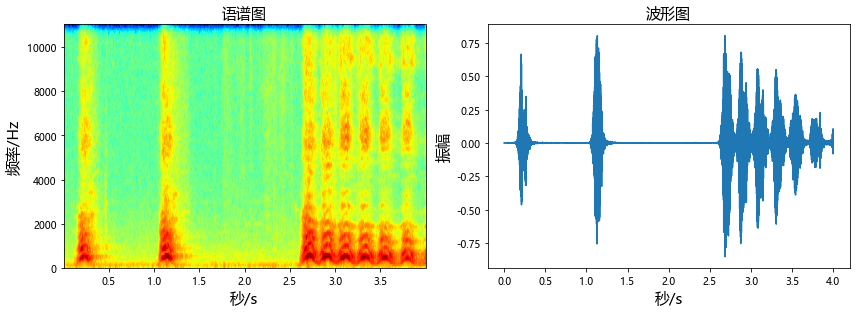

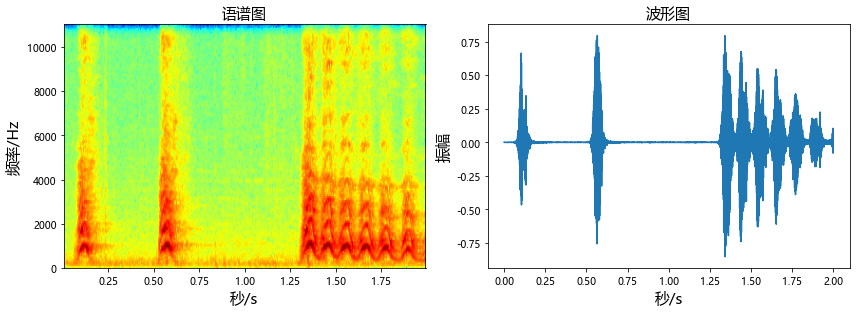

In [9]:
def resample(audio, target_sample_rate):
    return librosa.resample(audio, orig_sr=fs, target_sr=target_sample_rate)

augmented_audio = resample(signal_data, target_sample_rate=fs // 2)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 6. 音高修正
音高修正只改变音高而不影响音速，其中-5到5之间的步数更合适

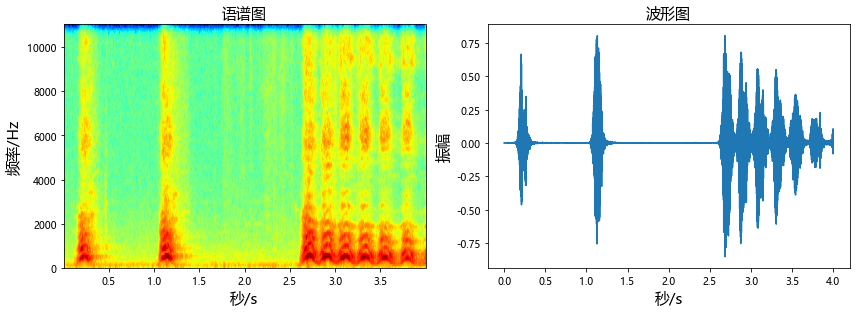

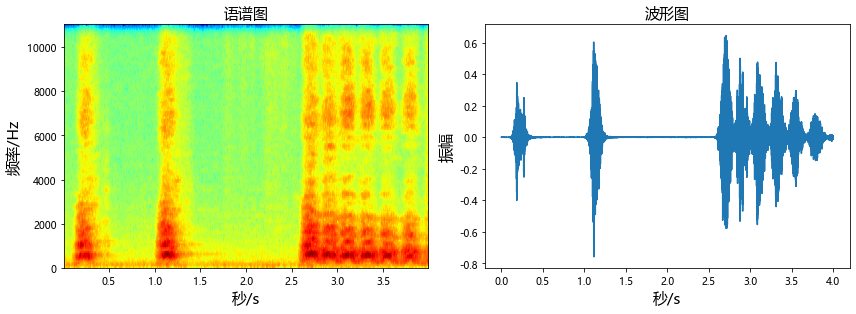

In [10]:
def pitch_shift(audio, sr, n_steps, bins_per_octave=12):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps, bins_per_octave=bins_per_octave)

augmented_audio = pitch_shift(signal_data, sr=fs, n_steps=3)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 7. 音频变速

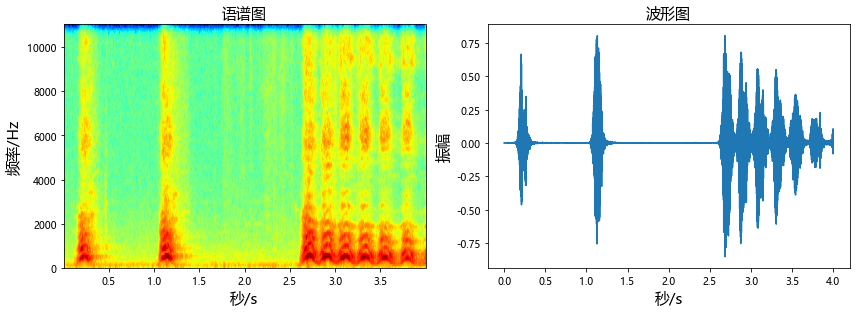

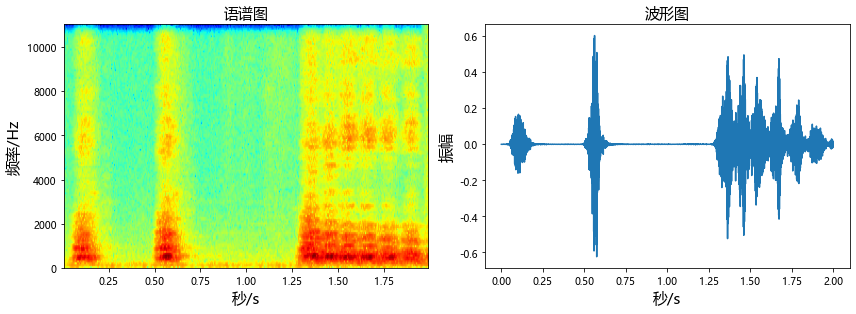

In [11]:
# 按固定速率对音频进行时间拉伸
def time_stretch(audio, rate):
    """
    :param rate: >1 加快；<1 减慢
    """
    return librosa.effects.time_stretch(audio, rate=rate)

augmented_audio = time_stretch(signal_data, rate=2)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 8. 时间掩码

时间掩码（Time Masking）是音频处理中的一种技术，用于在时域上对音频信号进行部分遮挡或消除。通过应用时间掩码，你可以在一段音频中选择性地屏蔽或删除一些时间区域，以实现特定的音频效果。

[SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/abs/1904.08779)

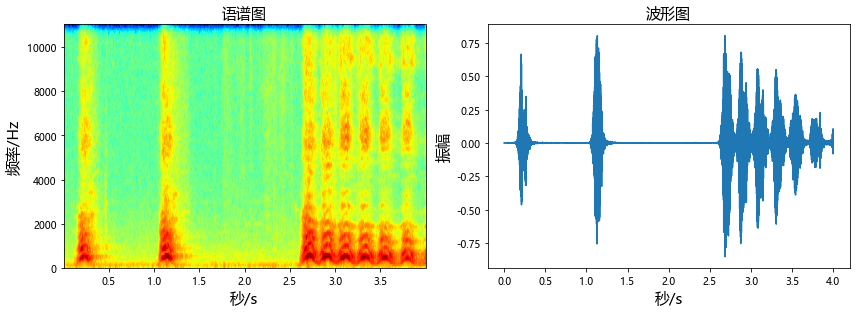

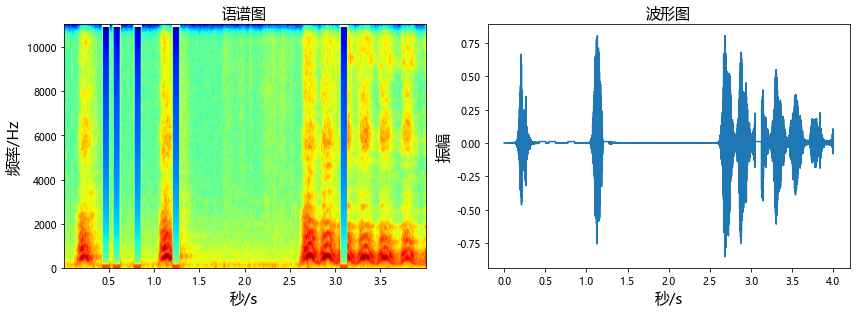

In [12]:
import copy
def time_mask(audio, num_mask=5, mask_percentage=0.02):
    mask_audio = copy.deepcopy(audio)
    mask_width = int(len(audio) * mask_percentage)
    for i in range(num_mask):
        mask_start = np.random.randint(low=0, high=len(mask_audio) - mask_width)
        mask_audio[mask_start:mask_start + mask_width] = 0.01
    return mask_audio

augmented_audio = time_mask(signal_data)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

## 9. 频率掩码
频率掩码（Frequency Masking）是音频处理中的一种技术，用于在频域上对音频信号进行部分遮挡或消除。通过应用频率掩码，你可以选择性地屏蔽或删除一些频率区域，以实现特定的音频效果，例如去除噪声、降低某些频率成分等。

(1025, 173)


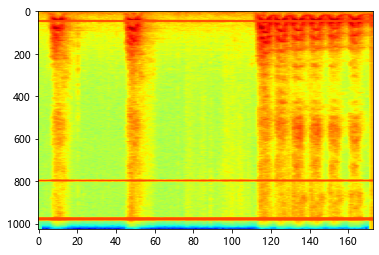

In [13]:
def frequency_mask(audio, num_mask, mask_percentage=0.01):
    spect, log_spect = get_spectrogram(audio)
    mask_width = int(mask_percentage * log_spect.shape[0])
    mask_log_spect = copy.deepcopy(log_spect)
    for i in range(num_mask):
        mask_start = np.random.randint(low=0, high=log_spect.shape[0] - mask_width)
        mask_log_spect[mask_start: mask_start + mask_width, :] = 0
    return mask_log_spect

augmented_spect = frequency_mask(signal_data, num_mask=4)
print(augmented_spect.shape)
plt.imshow(augmented_spect, aspect='auto', cmap='jet')
plt.show()

## 10. 滤波操作
### 10.1 高通滤波
高通滤波（High-Pass Filtering）是一种常见的信号处理技术，用于去除信号中低频成分，保留高频成分。在音频处理中，高通滤波器可以用来去除低频噪声、低频杂音或其他不需要的低频成分，从而提升信号的质量。

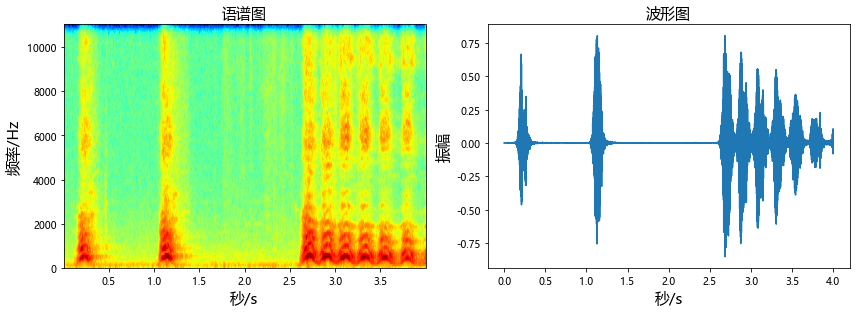

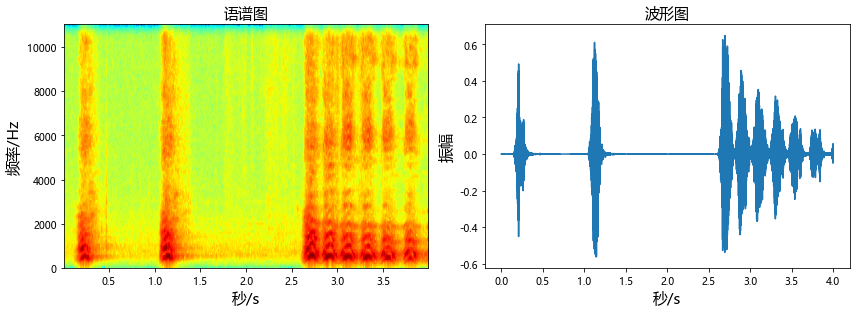

In [14]:
def high_pass_filter(audio, cutoff_freq, sample_rate):
    # 创建高通滤波器
    b, a = signal.butter(
        N=4,
        Wn=cutoff_freq / (sample_rate / 2),
        btype='high'
    )
    filtered_audio = signal.lfilter(b, a, audio)
    return filtered_audio

augmented_audio = high_pass_filter(signal_data, cutoff_freq=500, sample_rate=fs)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

### 10.2 低通滤波
低通滤波（Low-Pass Filtering）是一种常见的信号处理技术，用于去除信号中高频成分，保留低频成分。在音频处理中，低通滤波器可以用来去除高频噪声、高频失真或其他不需要的高频成分，从而改善信号的质量。

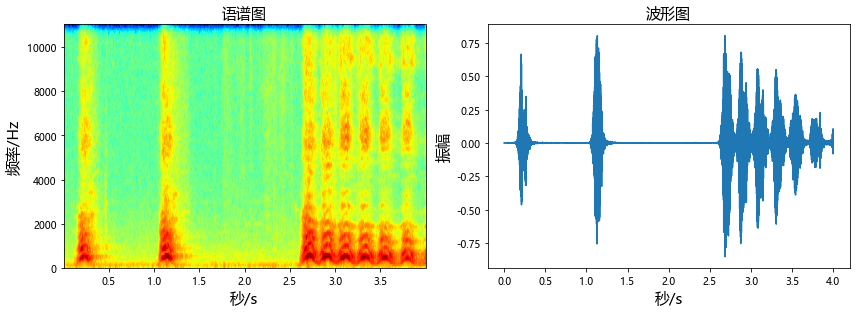

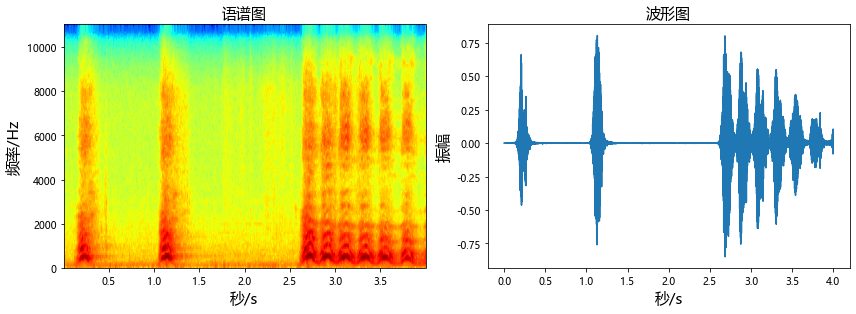

In [15]:
def low_pass_filter(audio, cutoff_freq, sample_rate):
    # 创建低通滤波器
    b, a = signal.butter(
        N=4,
        Wn=cutoff_freq / (sample_rate / 2),
        btype='low'
    )
    filtered_audio = signal.lfilter(b, a, audio)
    return filtered_audio

augmented_audio = low_pass_filter(signal_data, cutoff_freq=8000, sample_rate=fs)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

### 10.3 带通滤波
带通滤波（Band-Pass Filtering）是一种信号处理技术，用于保留信号在某一频率范围内的成分，而在其他频率范围内进行抑制。带通滤波器通常可以应用于音频处理中，以提取特定频率范围内的信号成分。

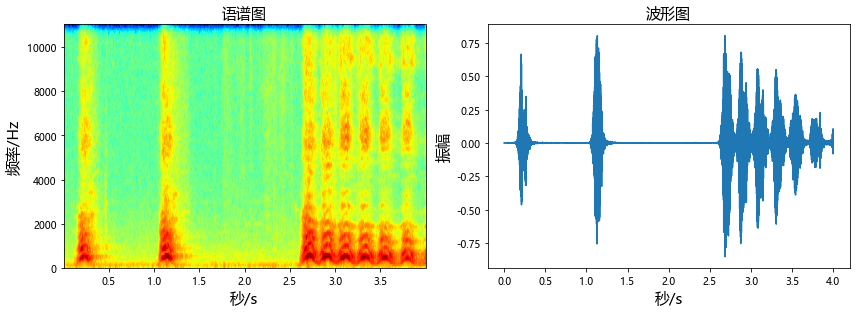

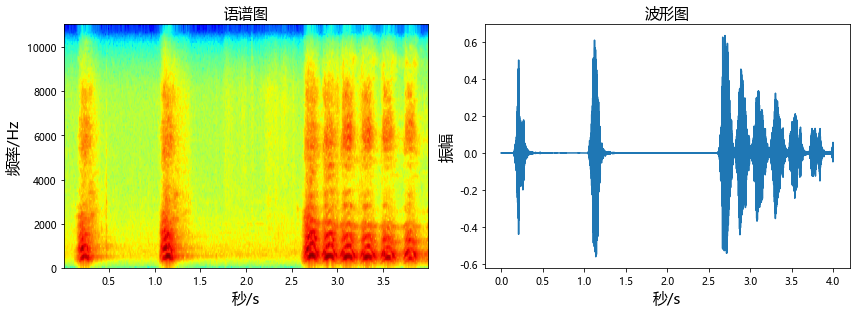

In [16]:
def band_pass_filter(audio, lowcut_freq, highcut_freq, sample_rate):
    # 创建带通滤波器
    b, a = signal.butter(
        N=4,
        Wn=[lowcut_freq / (sample_rate / 2), highcut_freq / (sample_rate / 2)],
        btype='band'
    )
    filted_audio = signal.lfilter(b, a, audio)
    return filted_audio

augmented_audio = band_pass_filter(
    audio=signal_data,
    lowcut_freq=500,
    highcut_freq=8000,
    sample_rate=fs
)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

### 10.4 带阻滤波
带阻滤波（Band-Stop Filtering），是一种用于去除特定频率范围内信号成分的滤波技术。带阻滤波器允许通过某个频率范围之外的信号，但在指定的频率范围内对信号进行抑制。

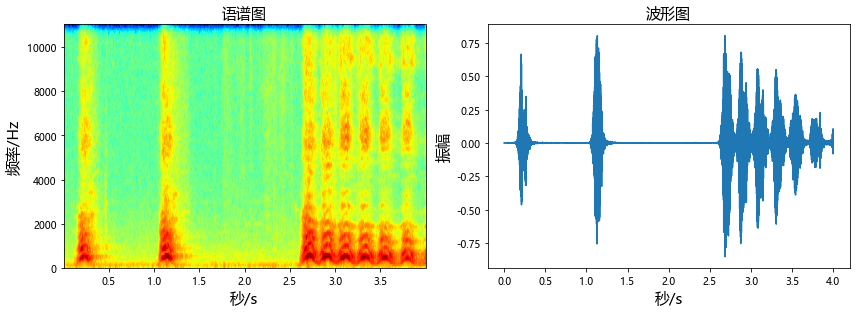

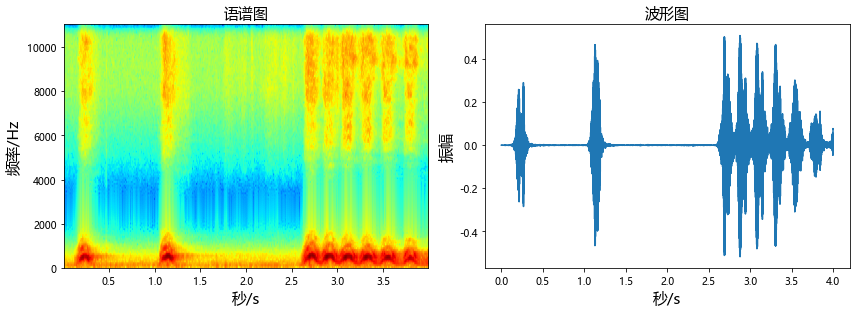

In [17]:
def band_stop_filter(audio, lowcut_freq, highcut_freq, sample_rate):
    # 创建带阻滤波器
    b, a = signal.butter(
        N=4,
        Wn=[lowcut_freq / (sample_rate / 2), highcut_freq / (sample_rate / 2)],
        btype='bandstop'
    )
    filted_audio = signal.lfilter(b, a, audio)
    return filted_audio

augmented_audio = band_stop_filter(
    audio=signal_data,
    lowcut_freq=500,
    highcut_freq=8000,
    sample_rate=fs
)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

### 10.5 陷波滤波
陷波滤波（Notch Filtering），也称为陷波滤波器或带阻滤波器，是一种信号处理技术，用于抑制特定频率范围内的信号成分，而保留其他频率成分。与带阻滤波类似，陷波滤波器的主要目的是去除特定频率范围内的噪声、干扰或其他不需要的信号成分。

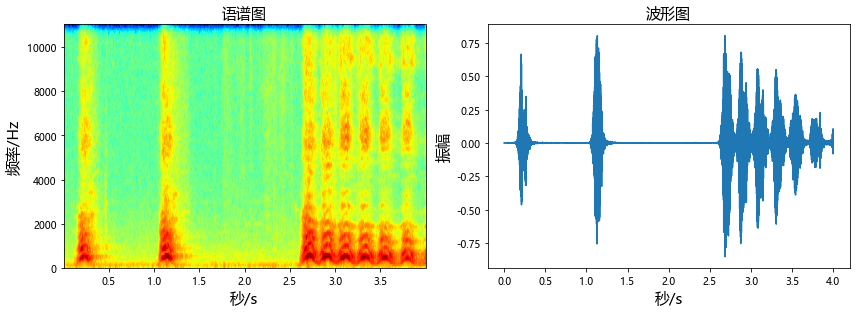

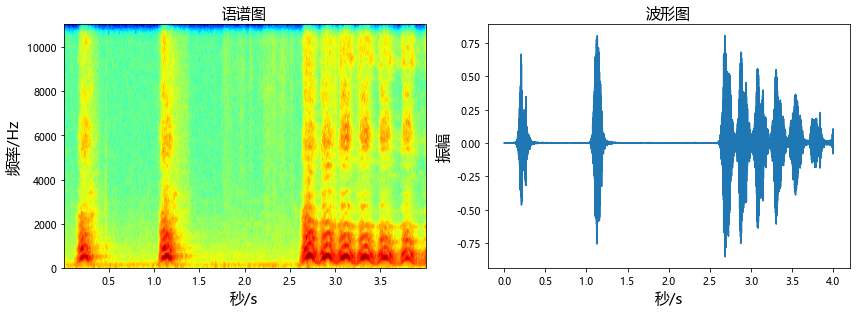

In [18]:
def notch_filter(audio, center_freq, bandwidth, sample_rate):
    # 创建陷波滤波器
    b, a = signal.iirnotch(
        w0=center_freq / (sample_rate / 2),
        Q=1.0 / bandwidth,
        fs=sample_rate
    )
    filted_audio = signal.lfilter(b, a, audio)
    return filted_audio

augmented_audio = notch_filter(signal_data, center_freq=1000, bandwidth=50, sample_rate=fs)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)

### 10.6 数字降噪滤波

数字降噪滤波（Digital Noise Reduction）是一种用于降低或去除数字信号中噪声成分的技术。这种技术可以应用于音频、图像、视频等数字信号的处理中，以改善信号的质量。数字降噪滤波在音频领域特别常见，用于去除背景噪声、环境噪声等不需要的声音成分。
1. 估计信号和噪声的功率谱密度
$$P_{xx}(f)=信号的功率谱密度$$
$$P_{nn}(f)=噪声的功率谱密度$$
2. 计算信号和噪声的功率谱比
$$SNR = 10 \cdot log_{10}(\frac {P_{xx}(f)} {P_{nn}(f))})$$
3. 生成自适应滤波器系数
$$自适应滤波器系数=1-\frac {P_{xx}(f)} {P_{nn}(f))}$$
4. 应用自适应滤波器
$$输出信号=输入信号 \cdot 自适应滤波器系数$$

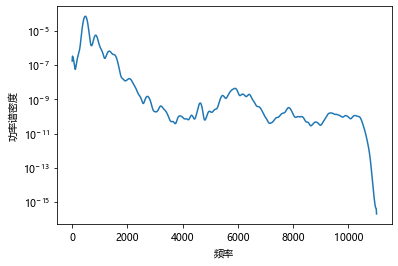

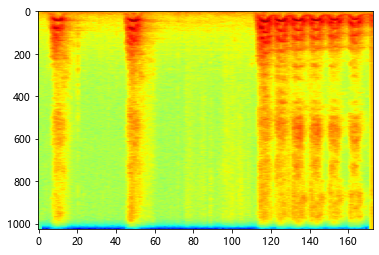

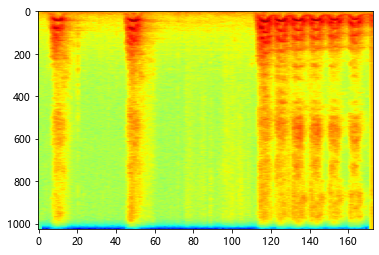

In [19]:
def digital_noise_reduce(audio, snr, sample_rate):
    # 估计信号和噪声的功率谱密度
    f, Pxx = signal.welch(audio, fs=sample_rate, nfft=2048)
    # 计算信号和噪声的功率谱比
    noise_Pxx = Pxx / (10 ** (snr / 10))
    # 生成自适应滤波器系数
    adaptive_filter = 1.0 - noise_Pxx / Pxx
    plt.semilogy(f, Pxx)
    plt.xlabel('频率')
    plt.ylabel('功率谱密度')
    plt.show()
    spect, log_spect = get_spectrogram(audio)
    filted_spect = adaptive_filter.reshape(len(adaptive_filter), 1) * log_spect
    return filted_spect

augmented_spect = digital_noise_reduce(signal_data, snr=5, sample_rate=fs)
spect, log_spect = get_spectrogram(signal_data)
plot_spect(log_spect)
plot_spect(augmented_spect)

### 10.8 小波降噪
小波降噪（Wavelet Denoising）是一种有效的信号降噪技术，它使用小波变换将信号分解成不同尺度的频带，然后通过处理适当的频带来降低噪声。小波降噪适用于多种信号类型，包括音频、图像和时间序列数据。

以下是小波降噪的一般步骤：

1. 小波分解：将原始信号进行小波变换，将信号分解成多个尺度的频带。不同尺度的频带包含不同频率范围内的信息。

2. 软阈值去噪：对每个频带的系数进行软阈值处理。软阈值处理是一种将幅度较小的系数设为零的操作，从而去除噪声成分。

3. 小波重构：将去噪后的系数进行小波逆变换，重构出降噪后的信号。

小波降噪的一个关键步骤是确定合适的阈值来进行软阈值处理。通常，阈值可以基于噪声估计或统计方法来确定。常见的阈值选择方法包括固定阈值、基于误差分布的阈值和基于真实信号与估计信号差异的阈值。

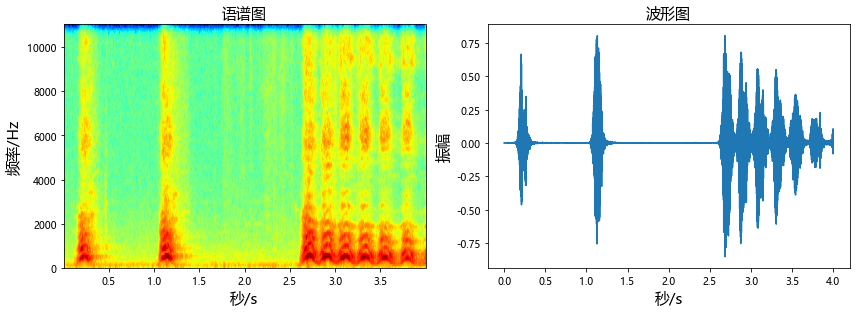

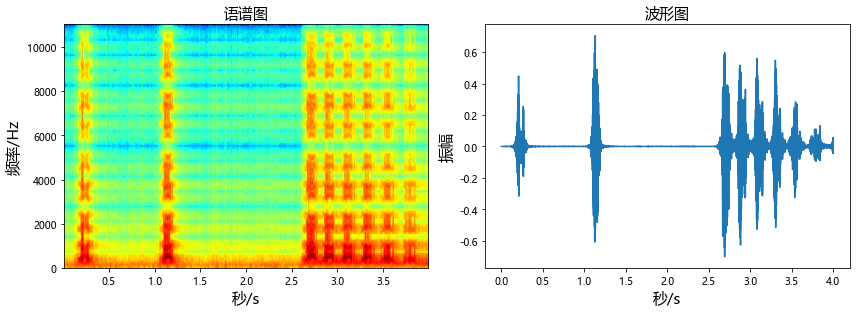

In [20]:
def wavelet_denoise(audio):
    # 小波降噪的参数
    wavelet = 'db4'  # 小波类型
    level = 5  # 小波分解的级数
    threshold_type = 'soft'  # 阈值处理类型
    # 小波分解
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    # 为每个频带的系数应用软阈值
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=0.5, mode=threshold_type)
    # 小波重构
    denoised_audio = pywt.waverec(coeffs, wavelet)
    return denoised_audio

augmented_audio = wavelet_denoise(signal_data)
plot_wave_spec(signal_data)
plot_wave_spec(augmented_audio)